In [52]:
from __future__ import division
import pandas as pd
import numpy as np
import glob
import seaborn as sns
from sklearn import metrics
from sklearn.utils import resample

import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import precision_score, accuracy_score, recall_score, roc_auc_score
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

import scipy
from rdkit.Chem import PandasTools

pd.set_option('display.max_colwidth', None)

# Read data & plot IC50 distributions

In [98]:
data = pd.read_csv('Data/DATA_with_all_FEATURES.csv')
#data = data.drop_duplicates(subset = 'Compound ID')
data = data.sort_values(by = 'date')
data = data.reset_index(drop = True)

/opt/miniconda3/envs/bedtools1/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


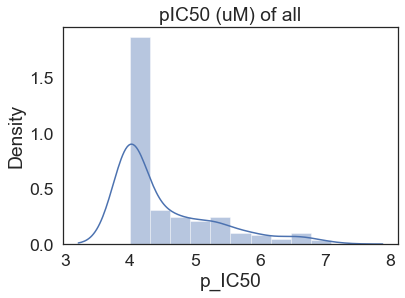

/opt/miniconda3/envs/bedtools1/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


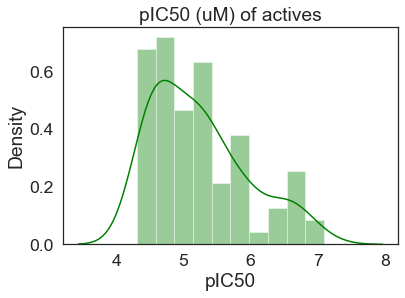

In [99]:
sns.set(font_scale=1.6)
sns.set_style("white")

plt.title('pIC50 (uM) of all')
sns.distplot(data['p_IC50']); plt.show()
plt.title('pIC50 (uM) of actives')
sns.distplot(data['p_IC50'][data['p_IC50'] >  4.30], bins = 10, color = 'green')
plt.xlabel('pIC50')
plt.savefig('PIC50_actives_dist.pdf'); plt.show()

# Scaffold split averaged across the four scaffolds

In [100]:
#Structure:
model = RandomForestClassifier(n_estimators = 100, max_depth = 3, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5']
label = ['p_IC50']
split = ['scaffold']
columns = feature_columns + label + split
df_analyse = data[columns]
cv = 10

roc_train_str = []; roc_test_str = []
for k in range(0, len(data['scaffold'].unique())):
    leave_out = data['scaffold'].value_counts().index[k]
    train_data = df_analyse[df_analyse['scaffold'] != leave_out]
    test_data = df_analyse[df_analyse['scaffold'] == leave_out]
    train_data = train_data.drop(columns = ['scaffold'])
    test_data = test_data.drop(columns = ['scaffold'])
   
    for t in range(0, cv):
        train_data_bs = resample(train_data, replace=True, n_samples = train_data.shape[0], random_state=t)
        train_data_diff = pd.DataFrame()
        for i in range(1, train_data_bs.shape[0]):
            train_data_diff_add = train_data_bs.diff(periods = i).dropna()
            train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
        train_data_diff_all = train_data_diff.copy()
        train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
        train_data_diff = train_data_diff.reset_index(drop = True)

        test_data_bs = resample(test_data, replace=True, n_samples = test_data.shape[0], random_state=t)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data_bs.shape[0]):
            test_data_diff_add = test_data_bs.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)
        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))
    
        train_labels = train_data_diff['p_IC50']
        train_features = train_data_diff.drop(columns = ['p_IC50'])
        train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
        model.fit(train_features, train_labels_comparison)

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        train_auc = roc_auc_score(train_labels_comparison, y_score_train[:,1])
        test_auc = roc_auc_score(test_labels_comparison, y_score_test[:,1])
        roc_train_str.append(train_auc)
        roc_test_str.append(test_auc)
print(str(np.mean(roc_train_str)) + '+/-' + str(np.std(roc_train_str)))
print(str(np.mean(roc_test_str)) + '+/-' + str(np.std(roc_test_str)))

0.8365143883351731+/-0.03424560679642768
0.7397766342668369+/-0.10368450616408


In [126]:
#Docking:
model = RandomForestClassifier(n_estimators = 100, max_depth = 3, max_features = 'sqrt', random_state = 0)
feature_columns = ['0_d', '1_d', '3_d', '4_d', '5_d']
label = ['p_IC50']
split = ['scaffold']
columns = feature_columns + label + split
df_analyse = data[columns]

roc_train_dock = []; roc_test_dock = []
for k in range(0, len(data['scaffold'].unique())):
    leave_out = data['scaffold'].value_counts().index[k]
    train_data = df_analyse[df_analyse['scaffold'] != leave_out]
    test_data = df_analyse[df_analyse['scaffold'] == leave_out]
    train_data = train_data.drop(columns = ['scaffold'])
    test_data = test_data.drop(columns = ['scaffold'])
   
    for t in range(0, cv):
        train_data_bs = resample(train_data, replace = True, n_samples = train_data.shape[0], random_state=t)
        train_data_diff = pd.DataFrame()
        for i in range(1, train_data_bs.shape[0]):
            train_data_diff_add = train_data_bs.diff(periods = i).dropna()
            train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
        train_data_diff_all = train_data_diff.copy()
        train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.5)  | (train_data_diff_all['p_IC50'] < -0.5)]
        train_data_diff = train_data_diff.reset_index(drop = True)

        test_data_bs = resample(test_data, replace = True, n_samples = test_data.shape[0], random_state=t)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data_bs.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)
        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))
    
        train_labels = train_data_diff['p_IC50']
        train_features = train_data_diff.drop(columns = ['p_IC50'])
        train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
        model.fit(train_features, train_labels_comparison)

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        train_auc = roc_auc_score(train_labels_comparison, y_score_train[:,1])
        test_auc = roc_auc_score(test_labels_comparison, y_score_test[:,1])
        roc_train_dock.append(train_auc)
        roc_test_dock.append(test_auc)
print(str(np.mean(roc_train_dock)) + '+/-' + str(np.std(roc_train_dock)))
print(str(np.mean(roc_test_dock)) + '+/-' + str(np.std(roc_test_dock)))

0.8945092384456279+/-0.03573256993421813
0.6897669924535549+/-0.13557667647337335


In [111]:
#Hybrid:
model = RandomForestClassifier(n_estimators = 100, max_depth = 2, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5', '0_d', '1_d', '2_d', '3_d', '4_d', '5_d']
label = ['p_IC50']
split = ['scaffold']
columns = feature_columns + label + split
df_analyse = data[columns]

roc_train_hybrid = []
roc_test_hybrid = []
for k in range(0, len(data['scaffold'].unique())):
    leave_out = data['scaffold'].value_counts().index[k]
    train_data = df_analyse[df_analyse['scaffold'] != leave_out]
    test_data = df_analyse[df_analyse['scaffold'] == leave_out]
    train_data = train_data.drop(columns = ['scaffold', '0_d', '1_d', '2_d', '3_d', '4_d', '5_d'])
    test_data = test_data.drop(columns = ['scaffold', '0', '1', '2', '3', '4', '5'])
   
    for t in range(0, cv):
        train_data_bs = resample(train_data, replace=True, n_samples = train_data.shape[0], random_state=t)
        train_data_diff = pd.DataFrame()
        for i in range(1, train_data_bs.shape[0]):
            train_data_diff_add = train_data_bs.diff(periods = i).dropna()
            train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
        train_data_diff_all = train_data_diff.copy()
        train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
        train_data_diff = train_data_diff.reset_index(drop = True)

        test_data_bs = resample(test_data, replace=True, n_samples = test_data.shape[0], random_state=t)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data_bs.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)
        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))
    
        train_labels = train_data_diff['p_IC50']
        train_features = train_data_diff.drop(columns = ['p_IC50'])
        train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
        model.fit(train_features, train_labels_comparison)

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        train_auc = roc_auc_score(train_labels_comparison, y_score_train[:,1])
        test_auc = roc_auc_score(test_labels_comparison, y_score_test[:,1])
        roc_train_hybrid.append(train_auc)
        roc_test_hybrid.append(test_auc)
print(str(np.mean(roc_train_hybrid)) + '+/-' + str(np.std(roc_train_hybrid)))
print(str(np.mean(roc_test_hybrid)) + '+/-' + str(np.std(roc_test_hybrid)))

0.8134543023545489+/-0.042851369006839723
0.7709658152133378+/-0.03773197888794868


In [102]:
#MFPs:
model = RandomForestClassifier(n_estimators = 50, max_depth = 2, max_features = 'sqrt', random_state = 0)
feature_columns = list(data.columns[data.columns.str.contains('Mgn')])
label = ['p_IC50']
split = ['scaffold']
columns = feature_columns + label + split
df_analyse = data[columns]

roc_train_MFP = []
roc_test_MFP = []
for k in range(0, len(df_analyse['scaffold'].unique())):
    leave_out = data['scaffold'].value_counts().index[k]
    train_data = df_analyse[df_analyse['scaffold'] != leave_out]
    test_data = df_analyse[df_analyse['scaffold'] == leave_out]
    train_data = train_data.drop(columns = ['scaffold'])
    test_data = test_data.drop(columns = ['scaffold'])
   
    for t in range(0, cv):
        train_data_bs = resample(train_data, replace=True, n_samples = test_data.shape[0], random_state=t)
        train_data_diff = pd.DataFrame()
        for i in range(1, train_data_bs.shape[0]):
            train_data_diff_add = train_data_bs.diff(periods = i).dropna()
            train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
        train_data_diff_all = train_data_diff.copy()
        train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
        train_data_diff = train_data_diff.reset_index(drop = True)

        test_data_bs = resample(test_data, replace=True, n_samples = test_data.shape[0], random_state=t)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data_bs.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)
        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))
    
        train_labels = train_data_diff['p_IC50']
        train_features = train_data_diff.drop(columns = ['p_IC50'])
        train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
        model.fit(train_features, train_labels_comparison)

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        train_auc = roc_auc_score(train_labels_comparison, y_score_train[:,1])
        test_auc = roc_auc_score(test_labels_comparison, y_score_test[:,1])
        roc_train_MFP.append(train_auc)
        roc_test_MFP.append(test_auc)
print(str(np.mean(roc_train_MFP)) + '+/-' + str(np.std(roc_train_MFP)))
print(str(np.mean(roc_test_MFP)) + '+/-' + str(np.std(roc_test_MFP)))

0.9616040012873682+/-0.04681221765210153
0.5222693101909375+/-0.12410672313306474


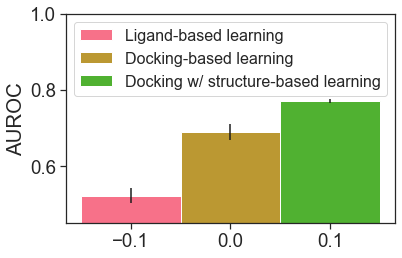

In [129]:
#Comparison plot:
sns.set(font_scale=1.7); sns.set_style("white"); sns.set_style("ticks")
sns.set_palette("husl")

x = np.arange(1)  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects2 = ax.bar(x - width, np.mean(roc_test_MFP), width, yerr = np.std(roc_test_MFP) / np.sqrt(40), label = 'Ligand-based learning')
rects3 = ax.bar(x + 0, np.mean(roc_test_dock), width, yerr = np.std(roc_test_dock) / np.sqrt(40), label = 'Docking-based learning')
rects4 = ax.bar(x + width, np.mean(roc_test_hybrid), width, yerr = np.std(roc_test_hybrid) / np.sqrt(40), label = 'Docking w/ structure-based learning')
#rects1 = ax.bar(x + width, np.mean(roc_test_str), width, yerr = np.std(roc_test_str)  / np.sqrt(40), label = 'Structure')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUROC')
plt.ylim([0.45, 1])
ax.legend(prop={'size': 16})
fig.tight_layout()
plt.savefig('Results/comparison_scaffolds.pdf')
plt.show()

In [128]:
print(np.mean(roc_test_dock[0:10]))
print(np.std(roc_test_dock[0:10]))
print(np.mean(roc_test_dock[10:20]))
print(np.std(roc_test_dock[10:20]))
print(np.mean(roc_test_dock[20:30]))
print(np.std(roc_test_dock[20:30]))
print(np.mean(roc_test_dock[30:40]))
print(np.std(roc_test_dock[30:40]))

0.5185264232541652
0.09509041354602776
0.6235679038832869
0.022513776521200353
0.7958017676767677
0.024016329896851298
0.8211718749999999
0.034380681348687686


In [138]:
np.mean(roc_test_hybrid)


0.7709658152133378

# What happens with the performance when the training data size is reduced

In [183]:
#FOR ODDT & for MFPs:
metadata = pd.read_csv('metadata.csv')
df_comb_all['name'] = df_comb_all['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
scaffold_dict = dict(zip(metadata['crystal_name'], metadata['site_name']))
df_comb_all['scaffold'] = df_comb_all['name'].map(scaffold_dict)
df_comb_all = df_comb_all[df_comb_all['scaffold'] != 'Chloroacetamide']

#For docking results:
combined_results = pd.read_csv('docking_oddt.csv')
combined_results['name'] = combined_results['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
combined_results['scaffold'] = combined_results['name'].map(scaffold_dict)
combined_results = combined_results[combined_results['scaffold'] != 'Chloroacetamide']

In [325]:
#ODDT:
#Combine data points first and calculate AUROC:
model = RandomForestClassifier(n_estimators = 300, max_depth = 5, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5']
label = ['p_IC50']
split = ['scaffold']
columns = feature_columns + label + split 
df_comb_all = df_comb_all.reset_index(drop = True)
leave_outs = ['Benzotriazole', 'Quinolone']
repeats = 10

#THs = [1, 0.8, 0.6, 0.4, 0.2]
THs = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
result_mean1 = np.zeros((repeats, len(THs)))
for t in range(0, repeats):
    RandomSeed = t
    np.random.seed(RandomSeed)
    for k in range(0, len(THs)):
        r1 = []; r2 = []
        df1 = df_comb_all[df_comb_all['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])].sample(frac = THs[k])
        df2 = df_comb_all[df_comb_all['scaffold'].isin(['Benzotriazole', 'Quinolone'])]
        df = pd.concat([df1, df2], axis = 0)
        print(df1.shape)
        train_labels_comparison = pd.Series()
        test_labels_comparison = pd.Series()
        y_score_train = []
        y_score_test = []

        for i in range(0, 2):
            df_analyse = df[columns]
            leave_out = leave_outs[i]
            train_data_full = df_analyse[df_analyse['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])]
            test_data_full = df_analyse[df_analyse['scaffold'] == leave_out]

            train_data = train_data_full.drop(columns = ['scaffold'])
            test_data = test_data_full.drop(columns = ['scaffold'])


            train_data_diff = pd.DataFrame()
            for i in range(1, train_data.shape[0]):
                train_data_diff_add = train_data.diff(periods = i).dropna()
                train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
            train_data_diff_all = train_data_diff.copy()
            train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
            train_data_diff = train_data_diff.reset_index(drop = True)

            test_data_diff = pd.DataFrame()
            for i in range(1, test_data.shape[0]):
                test_data_diff_add = test_data.diff(periods = i).dropna()
                test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
            test_data_diff_all = test_data_diff.copy()
            test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
            test_data_diff = test_data_diff.reset_index(drop = True)


            train_labels = train_data_diff['p_IC50']
            train_features = train_data_diff.drop(columns = ['p_IC50'])
            test_labels = test_data_diff['p_IC50']
            test_features = test_data_diff.drop(columns = ['p_IC50'])

            train_labels_comparison_temp = pd.Series(np.where(train_labels > 0, 0, 1))
            test_labels_comparison_temp = pd.Series(np.where(test_labels > 0, 0, 1))
            train_labels_comparison = pd.concat([train_labels_comparison, train_labels_comparison_temp], axis = 0)
            test_labels_comparison = pd.concat([test_labels_comparison, test_labels_comparison_temp], axis = 0)


            model.fit(train_features, train_labels_comparison_temp)
            y_score_train_temp = list(model.predict_proba(train_features)[:,1])
            y_score_test_temp = list(model.predict_proba(test_features)[:,1])
            y_score_train = y_score_train + y_score_train_temp
            y_score_test = y_score_test + y_score_test_temp

        train_auc = roc_auc_score(train_labels_comparison, y_score_train)
        test_auc = roc_auc_score(test_labels_comparison, y_score_test)

        print('test ' + str(k)  + ': ' + str(test_auc))
        result_mean1[t, k] = test_auc


(167, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6848929854710202
(150, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6877050460865489
(134, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6756756756756757
(117, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6609904702390251
(100, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.727230120293704
(84, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6670832682393375
(67, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6522418372129355
(50, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6584908608029996
(33, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.700984221215435
(17, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.5471801281049836
(167, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6769254803936884
(150, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6802062177784721
(134, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6891110763943133
(117, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6922355881893454
(100, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.7091079518825184
(84, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6636463052648024
(67, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.683330729573504
(50, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6775503827526949
(33, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6778628339321981
(17, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6620059365724105
(167, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6928604905483519
(150, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6909857834713327
(134, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6794250898297142
(117, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6973910326511482
(100, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6806748945477268
(84, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6652085611623184
(67, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.7033276050617092
(50, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6586470863927512
(33, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6489610998281519
(17, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6206842680831121
(167, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6959850023433839
(150, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.698640837369161
(134, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.7025464771129512
(117, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.7087955007030151
(100, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6625527261365411
(84, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6894235275738165
(67, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.65755350726449
(50, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6444305577253554
(33, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6648961099828152
(17, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6686455241368535
(167, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6841118575222622
(150, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.7147320731135761
(134, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6966099047023903
(117, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.7022340259334479
(100, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.666145914700828
(84, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6709889079831276
(67, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6972348070613967
(50, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.7053585377284799
(33, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6063115138259647
(17, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6866114669582877
(167, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6977034838306515
(150, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.7056709889079832
(134, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.7125449148570535
(117, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.7145758475238244
(100, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.702546477112951
(84, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.685361662240275
(67, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6697391032651149
(50, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6756756756756755
(33, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.7141071707545695
(17, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6630995157006717
(167, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6825496016247461
(150, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6919231370098422
(134, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6928604905483517
(117, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.7020778003436964
(100, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6655210123418216
(84, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6898922043430714
(67, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6973910326511482
(50, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.620684268083112
(33, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6091235744414936
(17, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6377128573660366
(167, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.7123886892673019
(150, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6866114669582879
(134, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6873925949070459
(117, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6695828776753632
(100, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.7000468676769255
(84, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6620840493672863
(67, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6478675206998906
(50, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6975472582408998
(33, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.5052335572566785
(17, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6334947664427433
(167, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6969223558818933
(150, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6748945477269176
(134, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.706139665677238
(117, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6733322918294016
(100, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6572410560849867
(84, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6927042649586002
(67, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6931729417278549
(50, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6864552413685362
(33, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.4543040149976566
(17, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6987970629589126
(167, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.690829557881581
(150, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6933291673176065
(134, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.7073894703952507
(117, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.7052023121387283
(100, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6887986252148102
(84, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6766130292141853
(67, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6464614903921262
(50, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6099047023902515
(33, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6716138103421341
(17, 39)


<ipython-input-325-c038e48b8d40>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-325-c038e48b8d40>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.542337134822684


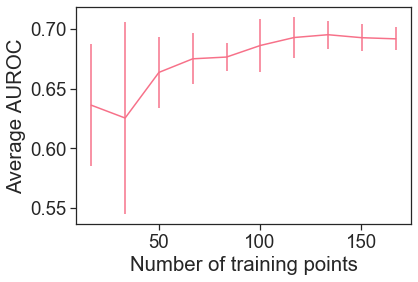

In [326]:
sns.set_style("ticks")
results_av = np.mean(result_mean1, axis = 0)
results_std = np.std(result_mean1, axis = 0)
coeff = df_comb_all[df_comb_all['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])].shape[0]
plt.errorbar([z*coeff for z in THs], results_av, yerr = results_std)
plt.xlabel('Number of training points')
plt.ylabel('Average AUROC')
plt.savefig('Learning_curve.eps')

In [333]:
#ODDT:
model = RandomForestClassifier(n_estimators = 300, max_depth = 5, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5']
label = ['p_IC50']
split = ['scaffold']
columns = feature_columns + label + split 
df_comb_all = df_comb_all.reset_index(drop = True)
leave_outs = ['Benzotriazole', 'Quinolone']
repeats = 10


THs = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
result_mean2 = np.zeros((repeats, len(THs)))
for t in range(0, 10):
    RandomSeed = t
    np.random.seed(RandomSeed)
    for k in range(0, len(THs)):
        r1 = []; r2 = []
        df1 = df_comb_all[~df_comb_all['scaffold'].isin(['Benzotriazole', 'Quinolone'])].sample(frac = THs[k])
        df2 = df_comb_all[df_comb_all['scaffold'] != 'Aminopyridine-like']
        df2 = df2[df2['scaffold'] != 'Isoquinoline']
        df = pd.concat([df1, df2], axis = 0)
        print(df1.shape)
        train_labels_comparison = pd.Series()
        test_labels_comparison = pd.Series()
        y_score_train = []
        y_score_test = []

        for i in range(0, 2):
            df_analyse = df[columns]
            leave_out = leave_outs[i]
            train_data_full = df_analyse[df_analyse['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])]
            test_data_full = df_analyse[df_analyse['scaffold'] == leave_out]

            train_data = train_data_full.drop(columns = ['scaffold'])
            test_data = test_data_full.drop(columns = ['scaffold'])


            train_data_diff = pd.DataFrame()
            for i in range(1, train_data.shape[0]):
                train_data_diff_add = train_data.diff(periods = i).dropna()
                train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
            train_data_diff_all = train_data_diff.copy()
            train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
            train_data_diff = train_data_diff.reset_index(drop = True)

            test_data_diff = pd.DataFrame()
            for i in range(1, test_data.shape[0]):
                test_data_diff_add = test_data.diff(periods = i).dropna()
                test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
            test_data_diff_all = test_data_diff.copy()
            test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
            test_data_diff = test_data_diff.reset_index(drop = True)


            train_labels = train_data_diff['p_IC50']
            train_features = train_data_diff.drop(columns = ['p_IC50'])
            test_labels = test_data_diff['p_IC50']
            test_features = test_data_diff.drop(columns = ['p_IC50'])

            train_labels_comparison_temp = pd.Series(np.where(train_labels > 0, 0, 1))
            test_labels_comparison_temp = pd.Series(np.where(test_labels > 0, 0, 1))
            train_labels_comparison = pd.concat([train_labels_comparison, train_labels_comparison_temp], axis = 0)
            test_labels_comparison = pd.concat([test_labels_comparison, test_labels_comparison_temp], axis = 0)


            model.fit(train_features, train_labels_comparison_temp)
            y_score_train_temp = list(model.predict_proba(train_features)[:,1])
            y_score_test_temp = list(model.predict_proba(test_features)[:,1])
            y_score_train = y_score_train + y_score_train_temp
            y_score_test = y_score_test + y_score_test_temp

        train_auc = roc_auc_score(train_labels_comparison, y_score_train)
        test_auc = roc_auc_score(test_labels_comparison, y_score_test)

        print('test ' + str(k)  + ': ' + str(test_auc))
        result_mean2[t, k] = test_auc


(185, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6895797531635682
(166, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.691610685830339
(148, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6912982346508357
(130, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6936416184971098
(111, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6898922043430714
(92, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6927042649586003
(74, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6878612716763005
(56, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6772379315731917
(37, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6203718169036088
(18, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6742696453679112
(185, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6794250898297142
(166, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6948914232151226
(148, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.697859709420403
(130, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6620840493672864
(111, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6498984533666614
(92, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.7212935478831433
(74, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6250585845961568
(56, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6769254803936885
(37, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6149039212623028
(18, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6024839868770504
(185, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.7036400562412124
(166, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6834869551632557
(148, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6906733322918295
(130, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.688486174035307
(111, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6788001874707077
(92, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.719418840806124
(74, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6255272613654116
(56, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.67317606623965
(37, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6481799718793939
(18, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6581784096234964
(185, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.7022340259334479
(166, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6886423996250587
(148, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.7050460865489766
(130, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6977034838306515
(111, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6820809248554913
(92, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6384939853147945
(74, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.693954069676613
(56, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6531791907514451
(37, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6002187158256522
(18, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6819246992657397
(185, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.7044211841899702
(166, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.7137947195750665
(148, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.692391813779097
(130, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.702546477112951
(111, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.7144196219340728
(92, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6675519450085924
(74, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.712388689267302
(56, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.693172941727855
(37, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.5083580690517107
(18, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6809873457272302
(185, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6848929854710202
(166, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.7111388845492891
(148, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6859865645992814
(130, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6939540696766131
(111, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6630214029057959
(92, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.7187939384471176
(74, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6700515544446181
(56, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6906733322918294
(37, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6752069989064209
(18, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6990314013435401
(185, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6658334635213248
(166, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6819246992657396
(148, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6733322918294018
(130, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6650523355725667
(111, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.710045305421028
(92, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.7011404468051866
(74, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6966099047023903
(56, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.7064521168567411
(37, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6349007967505077
(18, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.39853147945633494
(185, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.7000468676769255
(166, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6898922043430714
(148, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6848929854710202
(130, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6747383221371661
(111, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.7158256522418373
(92, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6378690829557881
(74, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6406811435713169
(56, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6528667395719419
(37, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.6297453522887049
(18, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6202155913138572
(185, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6947351976253711
(166, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6736447430089049
(148, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6983283861896578
(130, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6803624433682237
(111, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6997344164974222
(92, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6916106858303389
(74, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.7023902515231996
(56, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6717700359318856
(37, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.651616934853929
(18, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6378690829557883
(185, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 0: 0.6841118575222621
(166, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 1: 0.6984846117794095
(148, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 2: 0.6939540696766131
(130, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 3: 0.6992657397281675
(111, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 4: 0.6444305577253554
(92, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 5: 0.6580221840337448
(74, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 6: 0.6597406655210123
(56, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 7: 0.6502109045461647
(37, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 8: 0.681456022496485
(18, 39)


<ipython-input-333-d09e49c8a786>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-333-d09e49c8a786>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


test 9: 0.6503671301359163


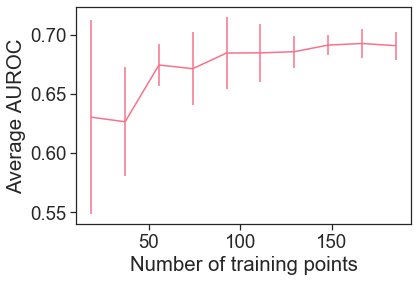

In [335]:
sns.set_style("ticks")
results_av = np.mean(result_mean2, axis = 0)
results_std = np.std(result_mean2, axis = 0)
coeff = df_comb_all[~df_comb_all['scaffold'].isin(['Benzotriazole', 'Quinolone'])].shape[0]
plt.errorbar([z*coeff for z in THs], results_av, yerr = results_std)
plt.xlabel('Number of training points')
plt.ylabel('Average AUROC')
plt.savefig('Learning_curve.eps')

In [342]:
185/219

0.8447488584474886

In [341]:
df_comb_all['scaffold'].value_counts().sum()

219

In [308]:
#ODDT:
#Calculate AUROCs separately and average
model = RandomForestClassifier(n_estimators = 300, max_depth = 5, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5']
label = ['p_IC50']
split = ['scaffold']
columns = feature_columns + label + split 
df_comb_all = df_comb_all.reset_index(drop = True)
leave_outs = ['Benzotriazole', 'Quinolone']
repeats = 5

THs = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
result_mean3 = np.zeros((repeats, len(THs)))
for t in range(0, repeats):
    RandomSeed = t
    np.random.seed(RandomSeed)
    for k in range(0, len(THs)):
        r1 = []; r2 = []
        df1 = df_comb_all[~df_comb_all['scaffold'].isin(['Benzotriazole', 'Quinolone'])].sample(frac = THs[k])
        df2 = df_comb_all[df_comb_all['scaffold'].isin(['Benzotriazole', 'Quinolone'])]
        df = pd.concat([df1, df2], axis = 0)
        print(df1.shape)
        train_labels_comparison = pd.Series()
        test_labels_comparison = pd.Series()
        y_score_train = []
        y_score_test = []

        aurocs = []
        for i in range(0, 2):
            df_analyse = df[columns]
            leave_out = leave_outs[i]
            train_data_full = df_analyse[~df_analyse['scaffold'].isin(['Benzotriazole', 'Quinolone'])]
            test_data_full = df_analyse[df_analyse['scaffold'] == leave_out]

            train_data = train_data_full.drop(columns = ['scaffold'])
            test_data = test_data_full.drop(columns = ['scaffold'])


            train_data_diff = pd.DataFrame()
            for i in range(1, train_data.shape[0]):
                train_data_diff_add = train_data.diff(periods = i).dropna()
                train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
            train_data_diff_all = train_data_diff.copy()
            train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
            train_data_diff = train_data_diff.reset_index(drop = True)

            test_data_diff = pd.DataFrame()
            for i in range(1, test_data.shape[0]):
                test_data_diff_add = test_data.diff(periods = i).dropna()
                test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
            test_data_diff_all = test_data_diff.copy()
            test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
            test_data_diff = test_data_diff.reset_index(drop = True)


            train_labels = train_data_diff['p_IC50']
            train_features = train_data_diff.drop(columns = ['p_IC50'])
            test_labels = test_data_diff['p_IC50']
            test_features = test_data_diff.drop(columns = ['p_IC50'])
            train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
            test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

            model.fit(train_features, train_labels_comparison)
            y_score_train = model.predict_proba(train_features)
            y_score_test = model.predict_proba(test_features)
            train_auc = roc_auc_score(train_labels_comparison, y_score_train[:,1])
            test_auc = roc_auc_score(test_labels_comparison, y_score_test[:,1])
            print(test_auc)
            print('test ' + str(k)  + ': ' + str(test_auc))
            aurocs.append(test_auc)
            result_mean3[t, k] = np.mean(aurocs)


(185, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7166666666666667
test 0: 0.7166666666666667
0.7736263736263737
test 0: 0.7736263736263737
(166, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7203703703703703
test 1: 0.7203703703703703
0.7934065934065934
test 1: 0.7934065934065934
(148, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7459876543209877
test 2: 0.7459876543209877
0.7472527472527473
test 2: 0.7472527472527473
(130, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7018518518518518
test 3: 0.7018518518518518
0.7846153846153846
test 3: 0.7846153846153846
(111, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7225308641975308
test 4: 0.7225308641975308
0.7736263736263737
test 4: 0.7736263736263737
(92, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7416666666666667
test 5: 0.7416666666666667
0.7406593406593407
test 5: 0.7406593406593407
(74, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6904320987654322
test 6: 0.6904320987654322
0.8285714285714286
test 6: 0.8285714285714286
(56, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6966049382716049
test 7: 0.6966049382716049
0.7648351648351649
test 7: 0.7648351648351649
(37, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6759259259259258
test 8: 0.6759259259259258
0.7428571428571429
test 8: 0.7428571428571429
(18, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7046296296296296
test 9: 0.7046296296296296
0.7736263736263737
test 9: 0.7736263736263737
(185, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.704320987654321
test 0: 0.704320987654321
0.7472527472527473
test 0: 0.7472527472527473
(166, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7450617283950617
test 1: 0.7450617283950617
0.7428571428571429
test 1: 0.7428571428571429
(148, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7438271604938271
test 2: 0.7438271604938271
0.7824175824175825
test 2: 0.7824175824175825
(130, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6709876543209877
test 3: 0.6709876543209877
0.7868131868131868
test 3: 0.7868131868131868
(111, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7444444444444445
test 4: 0.7444444444444445
0.6945054945054946
test 4: 0.6945054945054946
(92, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7719135802469136
test 5: 0.7719135802469136
0.7054945054945055
test 5: 0.7054945054945055
(74, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6225308641975308
test 6: 0.6225308641975308
0.7450549450549451
test 6: 0.7450549450549451
(56, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7503086419753087
test 7: 0.7503086419753087
0.6901098901098901
test 7: 0.6901098901098901
(37, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7095679012345679
test 8: 0.7095679012345679
0.6615384615384616
test 8: 0.6615384615384616
(18, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6421296296296297
test 9: 0.6421296296296297
0.5846153846153846
test 9: 0.5846153846153846
(185, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7126543209876542
test 0: 0.7126543209876542
0.7692307692307693
test 0: 0.7692307692307693
(166, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7114197530864198
test 1: 0.7114197530864198
0.7406593406593407
test 1: 0.7406593406593407
(148, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.733641975308642
test 2: 0.733641975308642
0.7714285714285715
test 2: 0.7714285714285715
(130, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7231481481481481
test 3: 0.7231481481481481
0.7296703296703296
test 3: 0.7296703296703296
(111, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6793209876543209
test 4: 0.6793209876543209
0.8043956043956044
test 4: 0.8043956043956044
(92, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7549382716049383
test 5: 0.7549382716049383
0.778021978021978
test 5: 0.778021978021978
(74, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6879629629629629
test 6: 0.6879629629629629
0.6351648351648351
test 6: 0.6351648351648351
(56, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7308641975308642
test 7: 0.7308641975308642
0.8
test 7: 0.8
(37, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6910493827160494
test 8: 0.6910493827160494
0.5164835164835165
test 8: 0.5164835164835165
(18, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6199074074074074
test 9: 0.6199074074074074
0.8307692307692308
test 9: 0.8307692307692308
(185, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7246913580246913
test 0: 0.7246913580246913
0.7868131868131868
test 0: 0.7868131868131868
(166, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7117283950617285
test 1: 0.7117283950617285
0.7230769230769231
test 1: 0.7230769230769231
(148, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7549382716049383
test 2: 0.7549382716049383
0.7450549450549451
test 2: 0.7450549450549451
(130, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7283950617283951
test 3: 0.7283950617283951
0.7428571428571429
test 3: 0.7428571428571429
(111, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7108024691358025
test 4: 0.7108024691358025
0.7912087912087912
test 4: 0.7912087912087912
(92, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6895061728395062
test 5: 0.6895061728395062
0.7384615384615385
test 5: 0.7384615384615385
(74, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7098765432098766
test 6: 0.7098765432098766
0.7362637362637363
test 6: 0.7362637362637363
(56, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7527777777777778
test 7: 0.7527777777777778
0.7186813186813187
test 7: 0.7186813186813187
(37, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6441358024691358
test 8: 0.6441358024691358
0.7648351648351649
test 8: 0.7648351648351649
(18, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7095679012345678
test 9: 0.7095679012345678
0.6681318681318681
test 9: 0.6681318681318681
(185, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7604938271604939
test 0: 0.7604938271604939
0.778021978021978
test 0: 0.778021978021978
(166, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7469135802469136
test 1: 0.7469135802469136
0.7648351648351648
test 1: 0.7648351648351648
(148, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7395061728395063
test 2: 0.7395061728395063
0.7274725274725276
test 2: 0.7274725274725276
(130, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7287037037037037
test 3: 0.7287037037037037
0.7582417582417583
test 3: 0.7582417582417583
(111, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7391975308641976
test 4: 0.7391975308641976
0.8263736263736264
test 4: 0.8263736263736264
(92, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6638888888888889
test 5: 0.6638888888888889
0.8043956043956044
test 5: 0.8043956043956044
(74, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7817901234567901
test 6: 0.7817901234567901
0.7274725274725274
test 6: 0.7274725274725274
(56, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.7459876543209877
test 7: 0.7459876543209877
0.7362637362637363
test 7: 0.7362637362637363
(37, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.4515432098765432
test 8: 0.4515432098765432
0.734065934065934
test 8: 0.734065934065934
(18, 39)


<ipython-input-308-8adc2291b392>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_labels_comparison = pd.Series()
<ipython-input-308-8adc2291b392>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_labels_comparison = pd.Series()


0.6702160493827161
test 9: 0.6702160493827161
0.7846153846153846
test 9: 0.7846153846153846


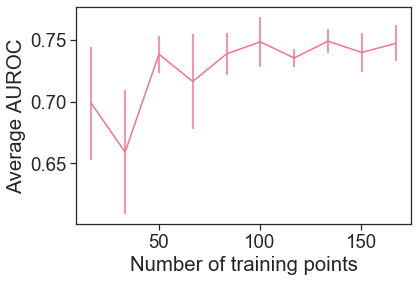

In [309]:
sns.set_style("ticks")
results_av = np.mean(result_mean3, axis = 0)
results_std = np.std(result_mean3, axis = 0)
coeff = df_comb_all[df_comb_all['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])].shape[0]
plt.errorbar([z*coeff for z in THs], results_av, yerr = results_std)
plt.xlabel('Number of training points')
plt.ylabel('Average AUROC')
plt.savefig('Learning_curve.eps')

In [311]:
#NB! In the end used the AUROC of both scaffolds combined (AUROCS are not additive)

In [176]:
    
#ODDT:
model = RandomForestClassifier(n_estimators = 300, max_depth = 5, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5']
label = ['p_IC50']
split = ['scaffold']
columns = feature_columns + label + split

THs = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
train_mean = []; train_std = []
test_mean = []; test_std = []
for k in range(0, len(THs)):
    r1 = []; r2 = []
    df_analyse = df_comb_all[columns]
    train_data_full = df_analyse[df_analyse['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])].sample(frac = THs[k])
    print(train_data_full.shape)
    for i in range(2, 4):
        leave_out = df_comb_all['scaffold'].value_counts().index[i]
        print(leave_out)
        test_data_full = df_analyse[df_analyse['scaffold'] == leave_out]
        train_data = train_data_full.drop(columns = ['scaffold'])
        test_data = test_data_full.drop(columns = ['scaffold'])

        train_data_diff = pd.DataFrame()
        for i in range(1, train_data.shape[0]):
            train_data_diff_add = train_data.diff(periods = i).dropna()
            train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
        train_data_diff_all = train_data_diff.copy()
        train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
        train_data_diff = train_data_diff.reset_index(drop = True)

        test_data_diff = pd.DataFrame()
        for i in range(1, test_data.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)

        train_labels = train_data_diff['p_IC50']
        train_features = train_data_diff.drop(columns = ['p_IC50'])
        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

        model.fit(train_features, train_labels_comparison)

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        train_auc = roc_auc_score(train_labels_comparison, y_score_train[:,1])
        test_auc = roc_auc_score(test_labels_comparison, y_score_test[:,1])

        print('test: ' + str(test_auc))
        r1.append(train_auc)
        r2.append(test_auc)
    train_mean.append(np.mean(r1))
    train_std.append(np.std(r1))
    test_mean.append(np.mean(r2))
    test_std.append(np.std(r2))

(167, 8)
Benzotriazole
test: 0.7160493827160493
Quinolone
test: 0.7846153846153846
(150, 8)
Benzotriazole
test: 0.7290123456790124
Quinolone
test: 0.7208791208791209
(134, 8)
Benzotriazole
test: 0.7280864197530864
Quinolone
test: 0.7802197802197802
(117, 8)
Benzotriazole
test: 0.6574074074074074
Quinolone
test: 0.7912087912087912
(100, 8)
Benzotriazole
test: 0.6626543209876543
Quinolone
test: 0.8285714285714286
(84, 8)
Benzotriazole
test: 0.7166666666666666
Quinolone
test: 0.7340659340659341
(67, 8)
Benzotriazole
test: 0.7759259259259259
Quinolone
test: 0.7010989010989012
(50, 8)
Benzotriazole
test: 0.7626543209876544
Quinolone
test: 0.7296703296703296
(33, 8)
Benzotriazole
test: 0.6540123456790123
Quinolone
test: 0.6637362637362637
(17, 8)
Benzotriazole
test: 0.6382716049382716
Quinolone
test: 0.7538461538461539
